In [9]:
import os, sys
import random

import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle as pkl
import torch

from shapreg import shapley, games, removal, shapley_sampling
from typing import List
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics

from denoising_diffusion_pytorch import Unet, GaussianDiffusion

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)

module_path = os.path.abspath(os.path.join('../CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets


/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [292]:
values = np.array([0.28668076, 0.36405554, 0.1677261 , 0.03354265, 0.32765463,
       0.00685869, 0.45971102, 0.14724274, 0.24388821, 0.16212487,
       0.04517788, 0.31616378, 0.20261958, 0.19266137, 0.4192155 ,
       0.03130813, 0.20554294])

min_val = np.min(values)
max_val = np.max(values)

normalized_values = 2 * ((values - min_val) / (max_val - min_val)) - 1

normalized_values

array([ 0.23582038,  0.57754229, -0.28953701, -0.88215161,  0.41677946,
       -1.        ,  1.        , -0.38000076,  0.04682919, -0.31427457,
       -0.83076519,  0.36603069, -0.13543168, -0.17941162,  0.82115353,
       -0.89202025, -0.1225208 ])

In [10]:
def plot_feature_values(feature_values, x_test):

    feature_num = feature_values.shape[1]
    ind = np.argpartition(np.abs(feature_values).mean(0).round(2), -feature_num)[-feature_num:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(feature_values[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        show=False
    )
    
    
    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('CRASH-2 - Shapley Value', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.4, -2.5, "TXA worse", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.4, -2.5, "TXA better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)

    plt.show()
    

def plot_feature_values_ind(feature_values, indices):
    
    feature_num = feature_values.shape[1]

    selected_sample = feature_values[indices]
    filtered_test = x_test[indices]
    
    ind = np.argpartition(np.abs(selected_sample).mean(0).round(2), -feature_num)[-feature_num:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(selected_sample[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        selected_sample[:, ind],
        filtered_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )

def min_max_norm(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train

def standardization(x_train):
    
    x_normalized_train = (x_train - np.mean(x_train, axis=0)) / (np.std(x_train, axis=0))

    return x_normalized_train

def subgroup_ate(
    method: str,
    features: List[int],
    y_true_train: np.ndarray,
    y_true_test: np.ndarray,
    estimated_ate_test: np.ndarray,
) -> None:
    
    xgb_model = xgb.XGBClassifier(  
        max_depth=10,
        reg_lambda=2,
        # min_split_loss=2
    )

    xgb_model.fit(x_train[:, features], y_true_train)

    y_pred = xgb_model.predict(x_test[:, features])
    y_pred_train = xgb_model.predict(x_train[:, features])
    
    ate = np.sum(estimated_ate_test[y_pred == 1])/len(estimated_ate_test)
    auroc = metrics.roc_auc_score(y_true_test, y_pred)
        
    print("===================")
    print("%s - auroc %s"%(method, auroc))
    print("%s - ATE %s"%(method, ate))

def feature_idx(
    method: str,
    cohort: str,
    learner: str
)-> List[int]:
    
    if method == "shap":
        file_path = f"../results/{cohort}/naive_shap_top_5_features_shuffle_{shuffle}_{learner}.csv"
    elif method == "ig":
        file_path = f"../results/{cohort}/integrated_gradients_top_5_features_shuffle_{shuffle}_{learner}.csv"
    elif method == "shap - 0 ":
        file_path = f"../results/{cohort}/shapley_value_sampling_top_5_features_shuffle_{shuffle}_{learner}.csv"
        
    df = pd.read_csv(file_path,keep_default_na=False)
    
    df_sorted = df.sort_values(
        by='count (%)', 
        ascending=False
    )
    print(df_sorted["feature"].head(5).tolist())
    
    indices  = [ data.columns.get_loc(col) for col in df_sorted["feature"].head(5) ]
    print(indices)
    
    indices = [i-1 if i > treatment_index else i for i in indices]
    indices = [i-1 if i > outcome_index else i for i in indices]

    return indices



In [77]:
outcome = "outcome"
treatment = "treatment_code"

data = pd.read_excel('../data/crash_2.xlsx')

data[outcome] = np.where(data["icause"].isna(), 1, 0)

data = data.drop(data[(data[treatment] == "P")|(data[treatment] == "D")].index)

continuous_vars = [
    "iage",
    'isbp',
    'irr',
    'icc',
    'ihr',
    'ninjurytime',
    'igcs'
    # 'igcseye',
    # 'igcsmotor',
    # 'igcsverbal',
]

cate_variables = [
    "iinjurytype"
]

binary_vars = [
    "isex"
]

data = data[continuous_vars + cate_variables + binary_vars + [treatment]+ [outcome]]
data["isex"] = np.where(data["isex"]== 2, 0, 1)

# deal with missing data
data["irr"] = np.where(data["irr"]== 0, np.nan,data["irr"])
data["isbp"] = np.where(data["isbp"] == 999, np.nan, data["isbp"])
data["ninjurytime"] = np.where(data["ninjurytime"] == 999, np.nan, data["ninjurytime"])
data["ninjurytime"] = np.where(data["ninjurytime"] == 0, np.nan, data["ninjurytime"])

data[treatment] = np.where(data[treatment] == "Active", 1, 0)
data = data[data.iinjurytype !=3 ]

data = pd.get_dummies(data, columns=cate_variables)

data["iinjurytype_1"] = np.where(data["iinjurytype_2"]== 1, 0, 1)
data.pop("iinjurytype_2")

names = data.drop([treatment, outcome], axis=1).columns


x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             data.loc[:, data.columns!= outcome],  
                                             data[outcome], 
                                             test_size=0.2, 
                                             random_state=42,
                                    )

x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                            x_train,
                                            y_train,
                                            test_size=0.2,
                                            random_state=42,
                                    )



x_num_train = x_train.loc[:,  ~x_train.columns.isin([treatment, "iinjurytype_1"])]
x_num_val =  x_val.loc[:,  ~x_val.columns.isin([treatment, "iinjurytype_1"])]
x_num_test = x_test.loc[:,  ~x_test.columns.isin([treatment, "iinjurytype_1"])]

x_cat_train = x_train.loc[:, x_train.columns.isin([treatment, "iinjurytype_1"]) ]
x_cat_val = x_val.loc[:, x_val.columns.isin([treatment, "iinjurytype_1"]) ]
x_cat_test = x_test.loc[:, x_test.columns.isin([treatment, "iinjurytype_1"]) ]

w_train = x_train.loc[:, x_train.columns == treatment]
w_val = x_val.loc[:, x_val.columns == treatment]
w_test = x_test.loc[:, x_test.columns == treatment]


np.save("X_cat_train", np.vectorize(str)(x_cat_train.values).astype('<U21'))
np.save("X_cat_val",  np.vectorize(str)(x_cat_val.values).astype('<U21'))
np.save("X_cat_test",  np.vectorize(str)(x_cat_test.values).astype('<U21'))

np.save("X_num_train", x_num_train.values)
np.save("X_num_val", x_num_val.values)
np.save("X_num_test", x_num_test.values)

print(x_cat_train.shape, x_num_train.shape, len(x_num_test))

np.save("y_train", y_train.values)
np.save( "y_val", y_val.values)
np.save( "y_test", y_test.values)

(10780, 2) (10780, 8) 3369


In [125]:
from sklearn.preprocessing import MinMaxScaler

outcome = "outcome"
treatment = "treatment_code"

data = pd.read_excel('../data/crash_2.xlsx')

data[outcome] = np.where(data["icause"].isna(), 1, 0)

data = data.drop(data[(data[treatment] == "P")|(data[treatment] == "D")].index)

continuous_vars = [
    "iage",
    'isbp',
    'irr',
    'icc',
    'ihr',
    'ninjurytime',
    'igcs'
    # 'igcseye',
    # 'igcsmotor',
    # 'igcsverbal',
]

cate_variables = [
    "iinjurytype"
]

binary_vars = [
    "isex"
]

data = data[continuous_vars + cate_variables + binary_vars + [treatment]+ [outcome]]
data["isex"] = np.where(data["isex"]== 2, 0, 1)

# deal with missing data
data["irr"] = np.where(data["irr"]== 0, np.nan,data["irr"])
data["isbp"] = np.where(data["isbp"] == 999, np.nan, data["isbp"])
data["ninjurytime"] = np.where(data["ninjurytime"] == 999, np.nan, data["ninjurytime"])
data["ninjurytime"] = np.where(data["ninjurytime"] == 0, np.nan, data["ninjurytime"])

data[treatment] = np.where(data[treatment] == "Active", 1, 0)
data = data[data.iinjurytype !=3 ]

scaler = MinMaxScaler()

data[continuous_vars] = scaler.fit_transform(data[continuous_vars])
data = pd.get_dummies(data, columns=cate_variables)

data["iinjurytype_1"] = np.where(data["iinjurytype_2"]== 1, 0, 1)
data.pop("iinjurytype_2")
# data.pop("iinjurytype_3")

names = data.drop([treatment, outcome], axis=1).columns 

In [106]:
# data = data.sample(1000)
        
n, feature_size = data.shape

treatment_index = data.columns.get_loc(treatment)
outcome_index = data.columns.get_loc(outcome)

var_index = [i for i in range(feature_size) if i not in [treatment_index, outcome_index]]

feature_names = data.drop([treatment, outcome], axis=1).columns

x_norm = data.values

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             data[outcome], 
                                             test_size=0.2, 
                                             random_state=42,
                                    )

x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                            x_train,
                                            y_train,
                                            test_size=0.2,
                                            random_state=42,
                                    )

w_train = x_train[:, treatment_index]
w_val = x_val[:, treatment_index]
w_test =  x_test[:, treatment_index]

x_train = x_train[:,var_index]
x_val = x_val[:,var_index]
x_test = x_test[:, var_index]

model = pseudo_outcome_nets.XLearner(  
    x_train.shape[1],
    binary_y=(len(np.unique(y_train)) == 2),
    n_layers_out=2,
    n_units_out=100,
    batch_size=128,
    n_iter=1500,
    nonlin="relu",
    device="cpu",
)

model.fit(x_train, y_train, w_train)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.7416253089904785, train_loss: 0.7694734930992126
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.3272227346897125, train_loss: 0.3328191637992859
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.3236185312271118, train_loss: 0.32021018862724304
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.32348132133483887, train_loss: 0.31617099046707153
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.3234061300754547, train_loss: 0.3144063651561737
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.4549063742160797, train_loss: 0.49575838446617126
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.2932744324207306, train_loss: 0.2997150719165802
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.29218819737434387, train_loss: 0.29403018951416016
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.29204

XLearner(
  (_te_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=9, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_po_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=9, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (_propensity_estimator)

In [134]:
import numpy as np

x_gen_num = np.load("X_num_unnorm.npy",  allow_pickle=True)
x_gen_cat = np.load("X_cat_unnorm.npy", allow_pickle=True )[:, 0].reshape(-1,1)

x_gen_num = scaler.fit_transform(x_gen_num)


sample_seq = np.concatenate([x_gen_num, x_gen_cat], axis=1)

In [135]:
x_gen_num

array([[0.75118068, 0.57748929, 0.65003237, ..., 0.77659148, 0.98365845,
        0.97689298],
       [0.69000335, 0.51284825, 0.77781341, ..., 0.75894383, 0.98420715,
        0.97282334],
       [0.7357396 , 0.45695426, 0.69923468, ..., 0.88516558, 0.98723235,
        0.97208819],
       ...,
       [0.74076216, 0.47876883, 0.62715757, ..., 0.78926678, 0.44939404,
        0.9752115 ],
       [0.71876438, 0.73682087, 0.75322815, ..., 0.80101799, 0.36848105,
        0.01417146],
       [0.65429723, 0.52967734, 0.76210514, ..., 0.77510275, 0.98648735,
        0.9740319 ]])

Permutation explainer: 10781it [09:24, 18.75it/s]                               


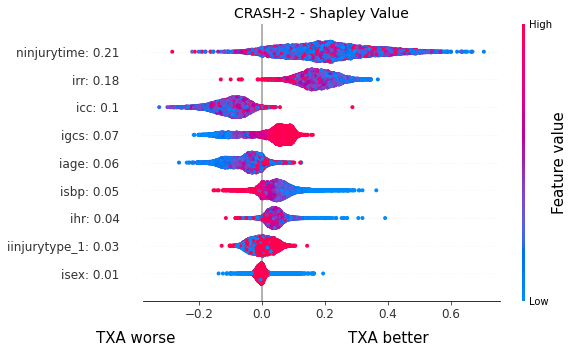

In [131]:
def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

# baseline = np.concatenate([x_train, x_val, x_test], axis=0)

explainer = shap.explainers.Permutation(model_predict, sample_seq)
shap_values = explainer(x_train)

plot_feature_values(shap_values.values, x_train)

Shapley Value Sampling attribution: 100%|███| 1001/1001 [01:00<00:00, 16.44it/s]


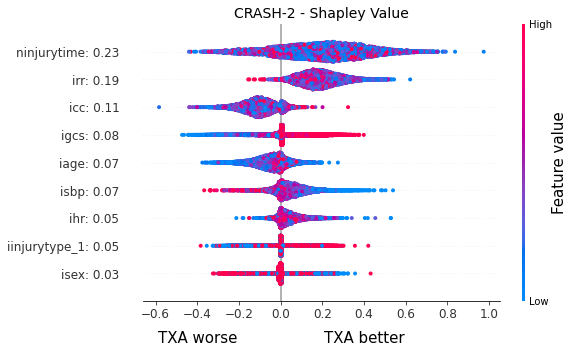

In [133]:
marginal_shapley_value_sampling_model = ShapleyValueSampling(model)

marginal_shapley_value = marginal_shapley_value_sampling_model.attribute(
                torch.tensor(x_train),
                n_samples=1000,
                baselines = torch.tensor(sample_seq),
                perturbations_per_eval = 10,
                show_progress=True
).detach().cpu().numpy()

plot_feature_values(marginal_shapley_value, x_train)

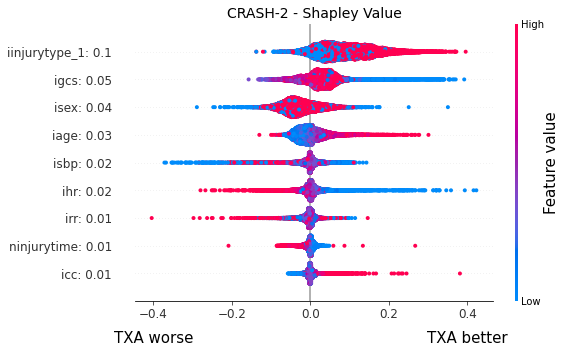

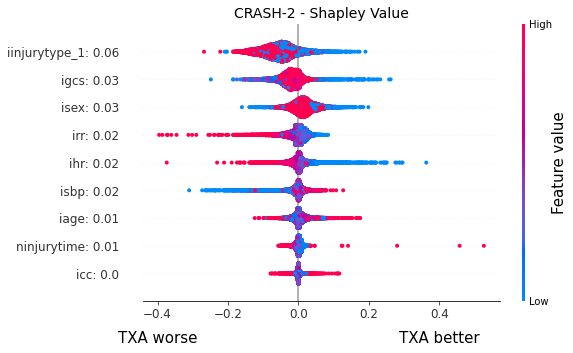

In [159]:
plot_feature_values(marginal_shapley_value, baseline)

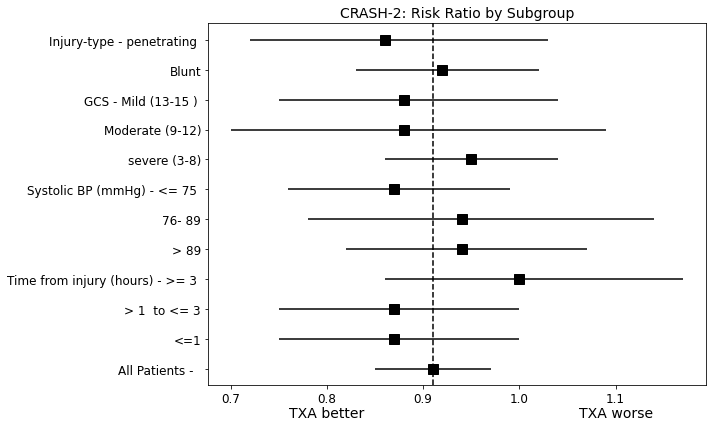

In [151]:
import matplotlib.pyplot as plt

# Data
data = [
    ["", 0.91, 0.85, 0.97,"All Patients"],
    ['<=1', 0.87, 0.75, 1.0, 'Time from injury (hours)'],
    ['> 1  to <= 3', 0.87, 0.75, 1.0, 'Time from injury (hours)'],
    ['>= 3', 1.0, 0.86, 1.17, 'Time from injury (hours)'],
    ['> 89', 0.94, 0.82, 1.07, 'Systolic BP (mmHg)'],
    ['76- 89', 0.94, 0.78, 1.14, 'Systolic BP (mmHg)'],
    ['<= 75', 0.87, 0.76, 0.99, 'Systolic BP (mmHg)'],
    ['severe (3-8)', 0.95, 0.86, 1.04, 'GCS'],
    ['Moderate (9-12)', 0.88, 0.70, 1.09, 'GCS'],
    ['Mild (13-15 )',0.88, 0.75, 1.04, 'GCS'],
    ['Blunt', 0.92, 0.83, 1.02, 'Injury-type'],
    ['penetrating', 0.86, 0.72, 1.03, 'Injury-type']
]

labels, medians, mins, maxs, categories = zip(*data)

# Compute the errors
lower_err = [median - min_ for median, min_ in zip(medians, mins)]
upper_err = [max_ - median for max_, median in zip(maxs, medians)]
errors = [lower_err, upper_err]

fig, ax = plt.subplots(figsize=(10,6))

# Plotting
y_range = range(len(labels))

# Reversing order
y_range = y_range[::-1]
medians = medians[::-1]
errors = [errors[0][::-1], errors[1][::-1]]

plt.errorbar(medians, y_range, xerr=errors, fmt='s', color="black", markersize=10)

# Set labels with category after range
new_labels = []
last_category = None
for label, min_, max_, category in reversed(list(zip(labels, mins, maxs, categories))):
    if category != last_category:
        new_labels.append(f'{category} - {label} ')
        last_category = category
    else:
        new_labels.append(f'{label}')

ax.set_yticks(y_range)
ax.set_yticklabels(new_labels, fontsize=12) # Larger font size here

ax.tick_params(axis='x', labelsize=12) # Larger font size for x-axis ticks

# Add custom text to the x-axis
ax.text(0.8, -1.6, "TXA better", color="black", ha="center", fontsize=16) # Larger font size here
ax.text(1.1, -1.6, "TXA worse", color="black", ha="center", fontsize=16) # Larger font size here

# Add a vertical dashed line at x = 0.91
ax.axvline(0.91, color='black', linestyle='--')

plt.title("CRASH-2: Risk Ratio by Subgroup", size=14)
plt.tight_layout()
plt.show()


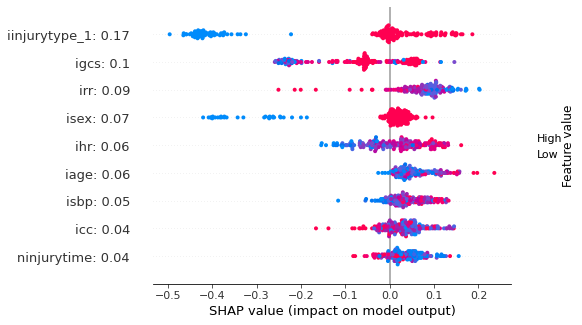

In [6]:
# print(learner_explanations["shapley_sampling"].shape)
plot_feature_values(learner_explanations["shapley_sampling"])

average tx effect 0.009062546917198233
average tx effect 0.00920967350252904


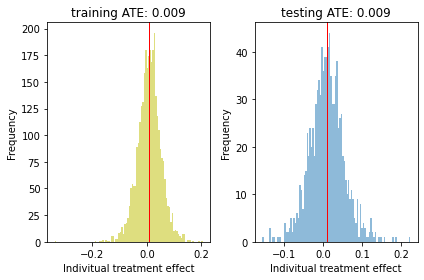

In [59]:
learner = "XLearner"
shuffle = "True"

results_train = pkl.load(open(f"../results/crash_2/train_shuffle_{shuffle}_{learner}.pkl", "rb"))
results_test = pkl.load(open(f"../results/crash_2/test_shuffle_{shuffle}_{learner}.pkl", "rb"))

print("average tx effect", np.mean(results_train))
print("average tx effect", np.mean(results_test))

plt.subplot(1,2,1)
plt.hist(np.mean(results_train, axis=0), bins=100 ,alpha= 0.5, color="y")
plt.axvline(x= np.mean(results_train), linewidth=1, color='r')

plt.title("training ATE: "+ str(np.round(np.mean(results_train), 3)))
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(np.mean(results_test, axis=0), bins=100, alpha = 0.5)
plt.axvline(x= np.mean(results_test), linewidth=1, color='r')

plt.title("testing ATE: "+ str(np.round(np.mean(results_test), 3)))
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

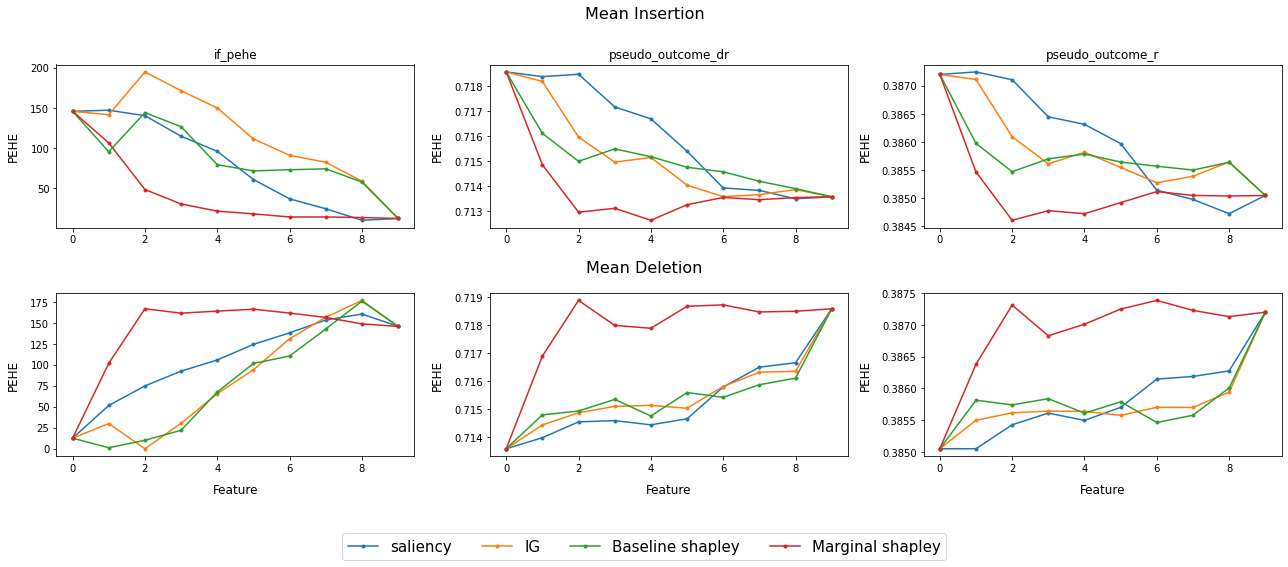

In [331]:
learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}
auroc_ate = {exp: [] for exp in explainers}

auroc_full = []
auroc_full_ate = []
auroc_random = []
auroc_random_ate = []

perturb_results = []

# Loop over the different files

seeds = [i for i in range(5)]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:
    file_path = f"../results/crash_2/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
    results = pkl.load(open(file_path,'rb'))
    
    for exp_index, exp in enumerate(explainers):
        auroc_all[exp].append(results[exp_index][5])
        auroc_ate[exp].append(results[exp_index][4])

        auroc_full.append(results[exp_index][7])
        auroc_full_ate.append(results[exp_index][6])

        auroc_random.append(results[exp_index][9])
        auroc_random_ate.append(results[exp_index][8])
        
        perturb_results.append(results[exp_index][10])
        
        for selection_type in selection_types:
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))


# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


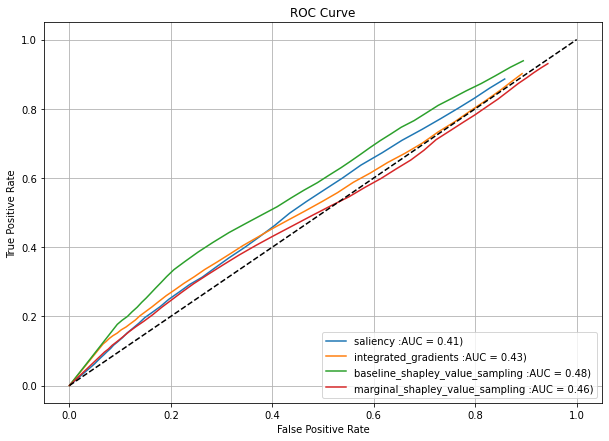

In [320]:
from sklearn.metrics import auc


plt.figure(figsize=(10, 7))

for i, exp in enumerate(explainers):
    
    data = np.mean(perturb_results[5*i:5*(i+1)], axis=0)

    # Calculate TPR and FPR
    tpr = data[:, 0] / (data[:, 0] + data[:, 3])
    fpr = data[:, 2] / (data[:, 2] + data[:, 1])

    # Sort FPR and TPR in ascending order of FPR for plotting
    sort_indices = np.argsort(fpr)
    fpr = fpr[sort_indices]
    tpr = tpr[sort_indices]

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{exp} :AUC = {auc(fpr, tpr):.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

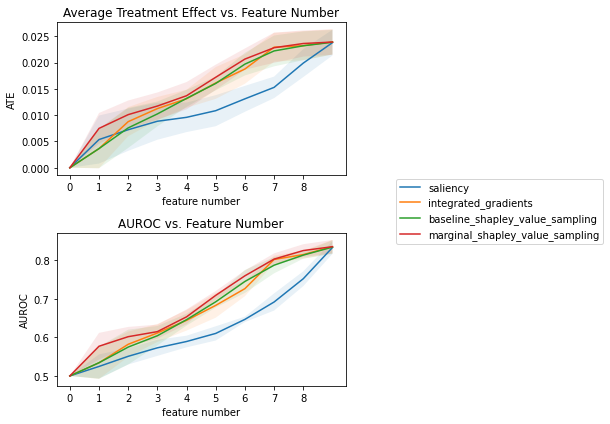

In [332]:
auroc_results  = {exp: np.array(result).mean(axis=0) for exp, result in auroc_all.items()}
auroc_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_all.items()}

ate_results = {exp:np.array(result).mean(axis=0) for exp, result in auroc_ate.items()}
ate_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_ate.items()}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,6))

# Plot ATE results
for k, v in ate_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax1.plot(feature_num, np.insert(v, 0, 0), label=k)
    ax1.fill_between(
        feature_num,
        np.insert(v, 0, 0) + np.insert(ate_std[k], 0, 0),
        np.insert(v, 0, 0) - np.insert(ate_std[k], 0, 0),
        alpha=0.1
    )

ax1.set_xticks(range(0, 9, 1))
ax1.set_xlabel("feature number")
ax1.set_ylabel("ATE")
ax1.set_title("Average Treatment Effect vs. Feature Number")

# Plot AUROC results
for k, v in auroc_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax2.plot(feature_num, np.insert(v, 0, 0.5), label=k)
    ax2.fill_between(
        feature_num,
        np.insert(v, 0, 0.5) + np.insert(auroc_std[k], 0, 0),
        np.insert(v, 0, 0.5) - np.insert(auroc_std[k], 0, 0),
        alpha=0.1
    )

ax2.set_xticks(range(0, 9, 1))
ax2.set_xlabel("feature number")
ax2.set_ylabel("AUROC")
ax2.set_title("AUROC vs. Feature Number")

# Adjust legend location
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.7, 0.5))

plt.tight_layout()
plt.show()


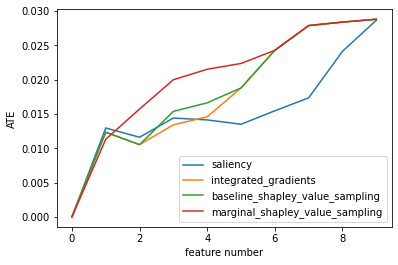

In [272]:
auroc_results_ate = {exp:np.array(result).mean(axis=0) for exp, result in auroc_ate.items()}

for k, v in auroc_results_ate.items():
    
    feature_num = [i for i in range(v.shape[0]+1)]
    plt.plot(feature_num, np.insert(v, 0, 0), label = k)


plt.xlabel("feature number")
plt.ylabel("ATE")
plt.legend()

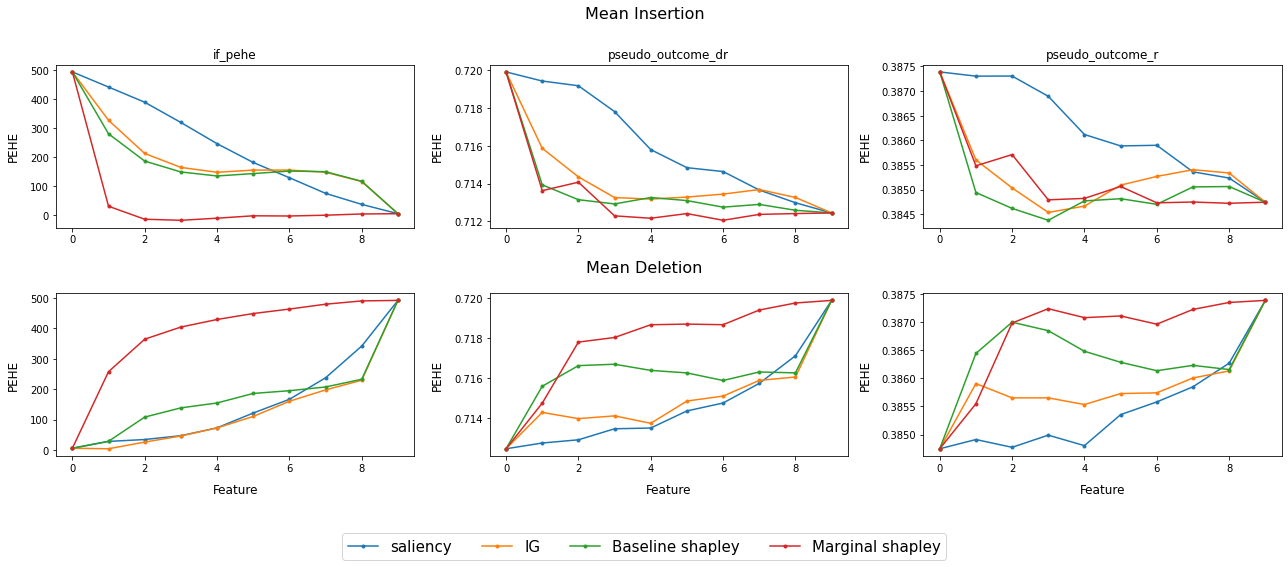

In [338]:
learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}
auroc_ate = {exp: [] for exp in explainers}

auroc_full = []
auroc_full_ate = []
auroc_random = []
auroc_random_ate = []

perturb_results = []

# Loop over the different files

seeds = [i for i in range(5)]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:
    file_path = f"../results/crash_2/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
    results = pkl.load(open(file_path,'rb'))
    
    for exp_index, exp in enumerate(explainers):
        auroc_all[exp].append(results[exp_index][5])
        auroc_ate[exp].append(results[exp_index][4])

        auroc_full.append(results[exp_index][7])
        auroc_full_ate.append(results[exp_index][6])

        auroc_random.append(results[exp_index][9])
        auroc_random_ate.append(results[exp_index][8])
        
        perturb_results.append(results[exp_index][10])
        
        for selection_type in selection_types:
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))


# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


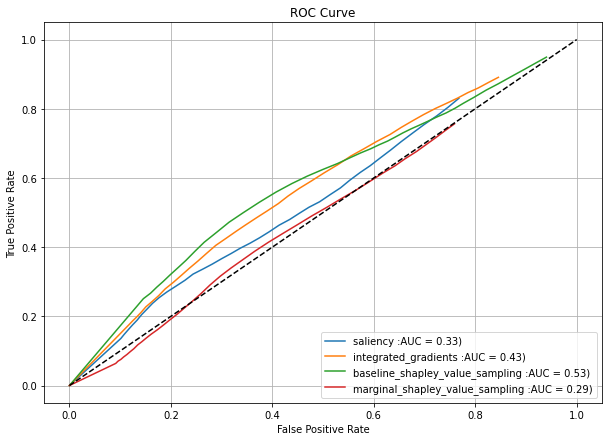

In [334]:
from sklearn.metrics import auc


plt.figure(figsize=(10, 7))

for i, exp in enumerate(explainers):
    
    data = np.mean(perturb_results[5*i:5*(i+1)], axis=0)

    # Calculate TPR and FPR
    tpr = data[:, 0] / (data[:, 0] + data[:, 3])
    fpr = data[:, 2] / (data[:, 2] + data[:, 1])

    # Sort FPR and TPR in ascending order of FPR for plotting
    sort_indices = np.argsort(fpr)
    fpr = fpr[sort_indices]
    tpr = tpr[sort_indices]

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{exp} :AUC = {auc(fpr, tpr):.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

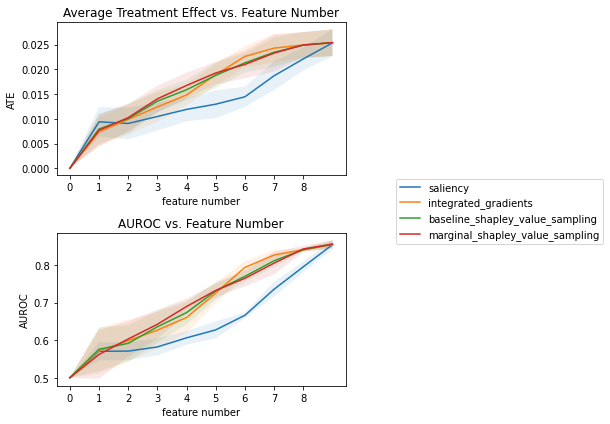

In [335]:
auroc_results  = {exp: np.array(result).mean(axis=0) for exp, result in auroc_all.items()}
auroc_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_all.items()}

ate_results = {exp:np.array(result).mean(axis=0) for exp, result in auroc_ate.items()}
ate_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_ate.items()}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,6))

# Plot ATE results
for k, v in ate_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax1.plot(feature_num, np.insert(v, 0, 0), label=k)
    ax1.fill_between(
        feature_num,
        np.insert(v, 0, 0) + np.insert(ate_std[k], 0, 0),
        np.insert(v, 0, 0) - np.insert(ate_std[k], 0, 0),
        alpha=0.1
    )

ax1.set_xticks(range(0, 9, 1))
ax1.set_xlabel("feature number")
ax1.set_ylabel("ATE")
ax1.set_title("Average Treatment Effect vs. Feature Number")

# Plot AUROC results
for k, v in auroc_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax2.plot(feature_num, np.insert(v, 0, 0.5), label=k)
    ax2.fill_between(
        feature_num,
        np.insert(v, 0, 0.5) + np.insert(auroc_std[k], 0, 0),
        np.insert(v, 0, 0.5) - np.insert(auroc_std[k], 0, 0),
        alpha=0.1
    )

ax2.set_xticks(range(0, 9, 1))
ax2.set_xlabel("feature number")
ax2.set_ylabel("AUROC")
ax2.set_title("AUROC vs. Feature Number")

# Adjust legend location
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.7, 0.5))

plt.tight_layout()
plt.show()
